<a href="https://colab.research.google.com/github/renjithsasidharan/layoutlmv3_cord/blob/main/Finetune_LayoutLMV3_on_CORD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `LayoutLMv3ForTokenClassification` on the [CORD](https://github.com/clovaai/cord) dataset. The goal for the model is to label words appearing in scanned documents (namely, receipts) appropriately. This task is treated as a NER problem (sequence labeling). However, compared to BERT, LayoutLMv3 also incorporates visual and layout information about the tokens when encoding them into vectors. This makes the LayoutLMv3 model very powerful for document understanding tasks.


* Paper: https://arxiv.org/abs/2204.08387
* Original repo: https://github.com/microsoft/unilm/tree/master/layoutlmv3

NOTES: 

* you first need to prepare the CORD dataset for LayoutLMv3. For that, check out the notebook "Prepare CORD for LayoutLMv3".
* this notebook is heavily inspired by [this Github repository](https://github.com/omarsou/layoutlm_CORD), which fine-tunes both BERT and LayoutLM (v1) on the CORD dataset.

In [ ]:
!rm -r transformers
!git clone -b add_layoutlmv3 https://github.com/NielsRogge/transformers
!cd transformers
!pip install -q ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 120926, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 120926 (delta 11), reused 20 (delta 10), pack-reused 120900
Receiving objects: 100% (120926/120926), 98.85 MiB | 20.47 MiB/s, done.
Resolving deltas: 100% (88413/88413), done.
Branch 'add_layoutlmv3' set up to track remote branch 'add_layoutlmv3' from 'origin'.
Switched to a new branch 'add_layoutlmv3'
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requir

In [ ]:
!pip install -q datasets seqeval

     |████████████████████████████████| 342 kB 7.0 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 136 kB 76.4 MB/s 
     |████████████████████████████████| 212 kB 84.2 MB/s 
     |████████████████████████████████| 1.1 MB 78.5 MB/s 
     |████████████████████████████████| 127 kB 91.3 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 99.5 MB/s 
     |████████████████████████████████| 271 kB 74.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Prepare the data

First, let's read in the annotations which we prepared in the other notebook. These contain the word-level annotations (words, labels, normalized bounding boxes).

In [ ]:
from collections import Counter
import pandas as pd

In [ ]:
train = pd.read_pickle('/content/drive/MyDrive/receipt-splitting/CORD/train.pkl')
val = pd.read_pickle('/content/drive/MyDrive/receipt-splitting/CORD/dev.pkl')
test = pd.read_pickle('/content/drive/MyDrive/receipt-splitting/CORD/test.pkl')

Let's define a list of all unique labels. For that, let's first count the number of occurrences for each label:

In [ ]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]

As we can see, there are some labels that contain very few examples. Let's replace them by the "neutral" label "O" (which stands for "Outside").

In [ ]:
replacing_labels = {'menu.etc': 'O', 'mneu.itemsubtotal': 'O', 'menu.sub_etc': 'O', 'menu.sub_unitprice': 'O', 'menu.vatyn': 'O',
                  'void_menu.nm': 'O', 'void_menu.price': 'O', 'sub_total.othersvc_price': 'O'}

In [ ]:
def replace_elem(elem):
  try:
    return replacing_labels[elem]
  except KeyError:
    return elem
def replace_list(ls):
  return [replace_elem(elem) for elem in ls]
train[1] = [replace_list(ls) for ls in train[1]]
val[1] = [replace_list(ls) for ls in val[1]]
test[1] = [replace_list(ls) for ls in test[1]]

In [ ]:
all_labels = [item for sublist in train[1] for item in sublist] + [item for sublist in val[1] for item in sublist] + [item for sublist in test[1] for item in sublist]
Counter(all_labels)

Counter({'O': 61,
         'menu.cnt': 2429,
         'menu.discountprice': 403,
         'menu.itemsubtotal': 7,
         'menu.nm': 6597,
         'menu.num': 109,
         'menu.price': 2585,
         'menu.sub_cnt': 189,
         'menu.sub_nm': 822,
         'menu.sub_price': 160,
         'menu.unitprice': 750,
         'sub_total.discount_price': 191,
         'sub_total.etc': 283,
         'sub_total.service_price': 353,
         'sub_total.subtotal_price': 1482,
         'sub_total.tax_price': 1283,
         'total.cashprice': 1393,
         'total.changeprice': 1297,
         'total.creditcardprice': 410,
         'total.emoneyprice': 129,
         'total.menuqty_cnt': 630,
         'total.menutype_cnt': 130,
         'total.total_etc': 89,
         'total.total_price': 2120})

In [ ]:
labels = list(set(all_labels))
print(labels)

['total.cashprice', 'total.total_price', 'sub_total.etc', 'menu.discountprice', 'total.menutype_cnt', 'total.menuqty_cnt', 'sub_total.subtotal_price', 'total.emoneyprice', 'menu.cnt', 'menu.nm', 'menu.price', 'total.changeprice', 'sub_total.service_price', 'sub_total.discount_price', 'menu.sub_cnt', 'menu.sub_price', 'menu.itemsubtotal', 'total.creditcardprice', 'O', 'sub_total.tax_price', 'total.total_etc', 'menu.num', 'menu.sub_nm', 'menu.unitprice']


In [ ]:
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}
print(label2id)
print(id2label)

{'total.cashprice': 0, 'total.total_price': 1, 'sub_total.etc': 2, 'menu.discountprice': 3, 'total.menutype_cnt': 4, 'total.menuqty_cnt': 5, 'sub_total.subtotal_price': 6, 'total.emoneyprice': 7, 'menu.cnt': 8, 'menu.nm': 9, 'menu.price': 10, 'total.changeprice': 11, 'sub_total.service_price': 12, 'sub_total.discount_price': 13, 'menu.sub_cnt': 14, 'menu.sub_price': 15, 'menu.itemsubtotal': 16, 'total.creditcardprice': 17, 'O': 18, 'sub_total.tax_price': 19, 'total.total_etc': 20, 'menu.num': 21, 'menu.sub_nm': 22, 'menu.unitprice': 23}
{0: 'total.cashprice', 1: 'total.total_price', 2: 'sub_total.etc', 3: 'menu.discountprice', 4: 'total.menutype_cnt', 5: 'total.menuqty_cnt', 6: 'sub_total.subtotal_price', 7: 'total.emoneyprice', 8: 'menu.cnt', 9: 'menu.nm', 10: 'menu.price', 11: 'total.changeprice', 12: 'sub_total.service_price', 13: 'sub_total.discount_price', 14: 'menu.sub_cnt', 15: 'menu.sub_price', 16: 'menu.itemsubtotal', 17: 'total.creditcardprice', 18: 'O', 19: 'sub_total.tax_pr

In [ ]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class CORDDataset(Dataset):
    """CORD dataset."""

    def __init__(self, annotations, image_dir, processor=None, max_length=256):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_dir (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes, self.image_file_names = annotations
        self.image_dir = image_dir
        #self.image_file_names = [(image_dir + "/" + f) for f in annotations[3]]
        self.processor = processor

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        # first, take an image
        item = self.image_file_names[idx]
        image = Image.open(self.image_dir + item).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)
        
        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
          encoded_inputs[k] = v.squeeze()

        # assert encoded_inputs.input_ids.shape == torch.Size([512])
        # assert encoded_inputs.attention_mask.shape == torch.Size([512])
        # assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        # assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        # assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        # assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [ ]:
from transformers import LayoutLMv3Processor, LayoutLMv3TokenizerFast, LayoutLMv3FeatureExtractor, LayoutLMv3ForTokenClassification

tokenizer = LayoutLMv3TokenizerFast.from_pretrained('microsoft/layoutlmv3-base')
processor = LayoutLMv3Processor(LayoutLMv3FeatureExtractor(apply_ocr=False), tokenizer)

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

In [ ]:
train_dataset = CORDDataset(annotations=train,
                            image_dir='/content/drive/MyDrive/receipt-splitting/CORD/train/image/', 
                            processor=processor)
val_dataset = CORDDataset(annotations=val,
                            image_dir='/content/drive/MyDrive/receipt-splitting/CORD/dev/image/', 
                            processor=processor)
test_dataset = CORDDataset(annotations=test,
                            image_dir='/content/drive/MyDrive/receipt-splitting/CORD/test/image/', 
                            processor=processor)

In [ ]:
encoding = train_dataset[0]

In [ ]:
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([709])
pixel_values torch.Size([3, 224, 224])


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

## Train the model

Let's train the model using native PyTorch. We use the AdamW optimizer with learning rate = 5e-5 (this is a good default value when fine-tuning Transformer-based models).



In [ ]:
model = LayoutLMv3ForTokenClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels=len(labels))

Downloading:   0%|          | 0.00/856 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AdamW
import torch
from tqdm.notebook import tqdm as tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 4

#put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        labels=labels) 
        loss = outputs.loss
        
        # print loss every 100 steps
        if global_step % 100 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

model.save_pretrained("/content/drive/MyDrive/receipt-splitting/layoutlmv3/Checkpoints")

Epoch: 0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:700: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


Loss after 0 steps: 3.1424672603607178
Loss after 100 steps: 1.2856905460357666
Loss after 200 steps: 0.2828967869281769
Loss after 300 steps: 0.4593961238861084
Epoch: 1


  0%|          | 0/400 [00:00<?, ?it/s]

Loss after 400 steps: 0.17135752737522125
Loss after 500 steps: 0.10753008723258972
Loss after 600 steps: 0.2537401616573334
Loss after 700 steps: 0.6396230459213257
Epoch: 2


  0%|          | 0/400 [00:00<?, ?it/s]

Loss after 800 steps: 0.014895085245370865
Loss after 900 steps: 0.1359490156173706
Loss after 1000 steps: 0.20585449039936066
Loss after 1100 steps: 0.05510126054286957
Epoch: 3


  0%|          | 0/400 [00:00<?, ?it/s]

Loss after 1200 steps: 0.06333038955926895
Loss after 1300 steps: 0.05786895751953125
Loss after 1400 steps: 0.06670865416526794
Loss after 1500 steps: 0.2547576427459717


## Evaluation

Let's evaluate the model on the test set. First, let's do a sanity check on the first example of the test set.

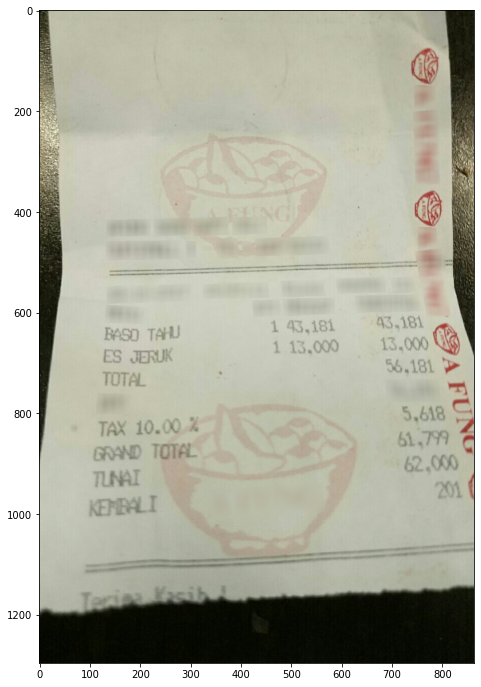

In [ ]:
import matplotlib.pyplot as plt

# Load image from local storage
img = Image.open("/content/drive/MyDrive/receipt-splitting/CORD/test/image/"+ test[3][0])
plt.figure(figsize = (8, 12))
plt.imshow(img, cmap='gray')

In [ ]:
encoding = test_dataset[0]
processor.tokenizer.decode(encoding['input_ids'])

for k,v in encoding.items():
  encoding[k] = v.unsqueeze(0).to(device)

model.eval()
# forward pass
outputs = model(input_ids=encoding['input_ids'],
                attention_mask=encoding['attention_mask'],
                bbox=encoding['bbox'],
                pixel_values=encoding['pixel_values'])

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:700: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [ ]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
print(prediction_indices)

[11, 9, 9, 9, 9, 9, 8, 23, 23, 23, 10, 10, 10, 9, 9, 9, 9, 8, 23, 23, 23, 10, 10, 10, 6, 6, 6, 6, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,

In [ ]:
prediction_indices = outputs.logits.argmax(-1).squeeze().tolist()
predictions = [id2label[label] for gt, label in zip(encoding['labels'].squeeze().tolist(), prediction_indices) if gt != -100]
print(predictions)

['menu.nm', 'menu.nm', 'menu.cnt', 'menu.unitprice', 'menu.price', 'menu.nm', 'menu.nm', 'menu.cnt', 'menu.unitprice', 'menu.price', 'sub_total.subtotal_price', 'sub_total.subtotal_price', 'sub_total.tax_price', 'sub_total.tax_price', 'sub_total.tax_price', 'sub_total.tax_price', 'total.total_price', 'total.total_price', 'total.total_price', 'total.cashprice', 'total.cashprice', 'total.changeprice', 'total.changeprice']


In [ ]:
import numpy as np

preds_val = None
out_label_ids = None

# put model in evaluation mode
model.eval()
def evaluate(dataloader):
  preds_val = None
  out_label_ids = None
  for batch in tqdm(dataloader, desc="Evaluating"):
      with torch.no_grad():
          input_ids = batch['input_ids'].to(device)
          bbox = batch['bbox'].to(device)
          attention_mask = batch['attention_mask'].to(device)
          pixel_values = batch['pixel_values'].to(device)
          labels = batch['labels'].to(device)

          # forward pass
          outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, 
                          pixel_values=pixel_values, labels=labels)
          
          if preds_val is None:
            preds_val = outputs.logits.detach().cpu().numpy()
            out_label_ids = batch["labels"].detach().cpu().numpy()
          else:
            preds_val = np.append(preds_val, outputs.logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, batch["labels"].detach().cpu().numpy(), axis=0
            )
  return preds_val, out_label_ids

In [ ]:
preds_val, out_label_ids = evaluate(test_dataloader)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:700: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score)

def results_test(preds, out_label_ids, labels):
  preds = np.argmax(preds, axis=2)

  label_map = {i: label for i, label in enumerate(labels)}

  out_label_list = [[] for _ in range(out_label_ids.shape[0])]
  preds_list = [[] for _ in range(out_label_ids.shape[0])]

  for i in range(out_label_ids.shape[0]):
      for j in range(out_label_ids.shape[1]):
          if out_label_ids[i, j] != -100:
              out_label_list[i].append(label_map[out_label_ids[i][j]])
              preds_list[i].append(label_map[preds[i][j]])

  results = {
      "precision": precision_score(out_label_list, preds_list),
      "recall": recall_score(out_label_list, preds_list),
      "f1": f1_score(out_label_list, preds_list),
  }
  return results, classification_report(out_label_list, preds_list)

In [ ]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.9055472263868066, 'recall': 0.9158453373768006, 'f1': 0.9106671692423671}
                         precision    recall  f1-score   support

                enu.cnt       0.98      0.95      0.97       224
      enu.discountprice       0.89      0.80      0.84        10
       enu.itemsubtotal       0.00      0.00      0.00         6
                 enu.nm       0.91      0.93      0.92       251
                enu.num       0.85      1.00      0.92        11
              enu.price       0.96      0.99      0.97       247
            enu.sub_cnt       0.85      1.00      0.92        17
             enu.sub_nm       0.75      0.84      0.79        32
          enu.sub_price       1.00      0.75      0.86        20
          enu.unitprice       0.94      1.00      0.97        68
         otal.cashprice       0.84      0.83      0.84        71
       otal.changeprice       0.83      0.92      0.87        59
   otal.creditcardprice       0.70      0.82   

In [ ]:
preds_val, out_label_ids = evaluate(val_dataloader)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
labels = list(set(all_labels))
val_result, class_report = results_test(preds_val, out_label_ids, labels)
print("Overall results:", val_result)
print(class_report)

Overall results: {'precision': 0.9200323101777059, 'recall': 0.9222672064777327, 'f1': 0.9211484027496968}
                         precision    recall  f1-score   support

                enu.cnt       1.00      0.95      0.97       213
      enu.discountprice       0.50      0.50      0.50         4
                 enu.nm       0.97      0.95      0.96       221
                enu.num       0.57      1.00      0.73         4
              enu.price       0.96      0.98      0.97       222
            enu.sub_cnt       0.79      0.97      0.87        32
             enu.sub_nm       0.80      0.89      0.84        45
          enu.sub_price       0.75      0.60      0.67        15
          enu.unitprice       0.94      0.98      0.96        52
         otal.cashprice       0.91      0.92      0.92        66
       otal.changeprice       0.86      0.92      0.89        66
   otal.creditcardprice       0.81      0.87      0.84        15
       otal.emoneyprice       0.60      0.75   